In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as Transformer
import torchvision.datasets as Datasets

In [28]:
# Creating Simple Discriminator using only linear layers
class Discriminator(nn.Module):
    def __init__(self,image_size):
        super().__init__()
        self.disc_mod = nn.Sequential(nn.Linear(image_size,256),
                                 nn.LeakyReLU(0.1),
                                 nn.Linear(256,128),
                                 nn.LeakyReLU(0.1),
                                 nn.Linear(128,64),
                                 nn.LeakyReLU(0.1),
                                 nn.Linear(64,1),
                                 nn.Sigmoid(),)
    def forward(self,x):
        return self.disc_mod(x)

In [37]:
#also Creating Simple Generator using only linear layers
class Generator(nn.Module):
    def __init__(self,latent,image_input):
        super().__init__()
        self.gen_mod = nn.Sequential(nn.Linear(latent,256,),
                                nn.LeakyReLU(0.1),
                                nn.LeakyReLU(0.1),
                                nn.Linear(256,128),
                                nn.LeakyReLU(0.1),
                                nn.Linear(128,64),
                                nn.LeakyReLU(0.1),
                                nn.Linear(64,image_size),
                                nn.Tanh(),)
    def forward(self,x):
        return self.gen_mod(x)

In [38]:
#writing device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
# setting hyperparameters
learning_rate = 3e-4
latent = 128
image_size = 28*28*1
batch_size = 32
epochs = 30

In [40]:
# creating the objects of the model classes and sending them to device (if cude is avaiable). Here I don't have GPU
disc_obj = Discriminator(image_size).to(device)
gen_obj = Generator(latent,image_size).to(device)

fixed_noise = torch.randn(batch_size,latent).to(device)

# creating a transformation for data
transforms = Transformer.Compose([Transformer.ToTensor(), 
                                  Transformer.Normalize((0.5,),(0.5,))]
)

# downloading dataset, transforming and making a dataloader object
dataset = Datasets.MNIST(root="/datasets",transform = transforms, download=True)
loader = DataLoader(dataset,batch_size = batch_size, shuffle=True)

In [41]:
# making optimizers for respective models
disc_optim = torch.optim.Adam(disc_obj.parameters(),lr=learning_rate)
gen_optim = torch.optim.Adam(gen_obj.parameters(),lr=learning_rate)

In [42]:
# defining the loss function, specifically the criterion
criterion = nn.BCELoss()

In [ ]:
criterion = nn.BCELoss()

In [ ]:
####disc_real = disc(real).view(-1)

In [46]:
disc_loss = []
gen_loss = []
for epoch in range(epochs):
    
    for index,(real,_) in enumerate(loader):
        #for reshaping the real into (batch size,flattened image size), 28x28 is the image size of MNIST dataset, so 
        real = real.view(-1,28*28).to(device)
        batch_size = real.shape[0]
        
        # its a fake dataset with the batch size and latent vairable which is just fake rows of same size (as of input of generator)
        noise = torch.randn(batch_size,latent).to(device)
        #passing noise to generator model and getting the output of needed size
        fake = gen_obj(noise)
        
        #calculating loss for discriminator for real part
        disc_real = disc_obj(real).view(-1)
        disc_real_loss = criterion(disc_real,torch.ones_like(disc_real))
        
        #calculating loss for discriminator for fake part
        disc_fake = disc_obj(fake).view(-1)
        disc_fake_loss = criterion(disc_fake,torch.zeros_like(disc_fake))
        
        #calculating discriminator criterion 
        disc_criterion = (disc_real_loss+disc_fake_loss)/2
        
        disc_obj.zero_grad()
        disc_criterion.backward(retain_graph=True)
        disc_optim.step()
        
        #calculating generator criterion
        out = disc_obj(fake).view(-1)
        gen_criterion = criterion(out,torch.ones_like(out))
        
        gen_obj.zero_grad()
        gen_criterion.backward()
        gen_optim.step()
        
        if index == 0:
            disc_loss.append(disc_criterion)
            gen_loss.append(gen_criterion)
            print(
            f"Epoch[{epoch}/{epochs}] Loss D: {disc_criterion:.4f}, Loss G: {gen_criterion}"
            )

Epoch[0/30] Loss D: 0.6326, Loss G: 0.6556177139282227
Epoch[1/30] Loss D: 0.4277, Loss G: 4.156589984893799
Epoch[2/30] Loss D: 0.2560, Loss G: 5.031439781188965
Epoch[3/30] Loss D: 0.2675, Loss G: 2.9391422271728516
Epoch[4/30] Loss D: 0.1281, Loss G: 2.78663969039917
Epoch[5/30] Loss D: 0.1656, Loss G: 2.7487823963165283
Epoch[6/30] Loss D: 0.0461, Loss G: 3.6343250274658203
Epoch[7/30] Loss D: 0.0881, Loss G: 3.3692963123321533
Epoch[8/30] Loss D: 0.1495, Loss G: 3.215775728225708
Epoch[9/30] Loss D: 0.0741, Loss G: 3.3964715003967285
Epoch[10/30] Loss D: 0.1829, Loss G: 1.7728264331817627
Epoch[11/30] Loss D: 0.2112, Loss G: 1.872462272644043
Epoch[12/30] Loss D: 0.1595, Loss G: 2.7073116302490234
Epoch[13/30] Loss D: 0.2168, Loss G: 2.390434980392456
Epoch[14/30] Loss D: 0.2851, Loss G: 2.114976167678833
Epoch[15/30] Loss D: 0.2237, Loss G: 2.341750144958496
Epoch[16/30] Loss D: 0.3471, Loss G: 2.1070556640625
Epoch[17/30] Loss D: 0.3643, Loss G: 1.9745821952819824
Epoch[18/30] L

In [48]:
epoch_list = [x for x in range(epochs)]

In [52]:
d_loss = [x.detach().numpy() for x in disc_loss]
g_loss = [x.detach().numpy() for x in gen_loss]

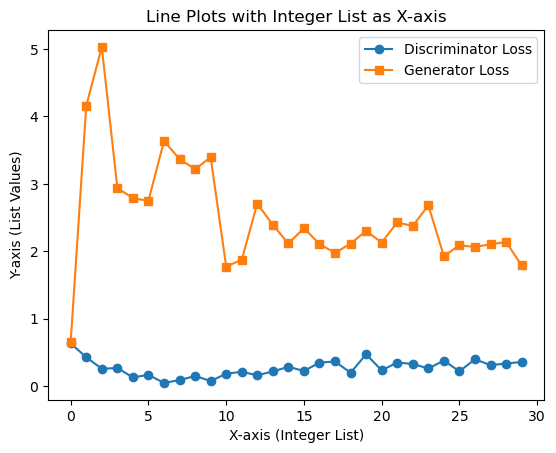

In [54]:
import matplotlib.pyplot as plt
plt.plot(epoch_list,d_loss,label="Discriminator Loss",marker="o")
plt.plot(epoch_list,g_loss,label="Generator Loss",marker="s")

plt.xlabel('X-axis (Integer List)')
plt.ylabel('Y-axis (List Values)')
plt.title('Line Plots with Integer List as X-axis')
plt.legend()

plt.show()